In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

import logging
import pickle
from datetime import datetime
import os
from data_processing import gen_ckpt_steps
from conv_plots_funcs import get_seg_starts_per_config
import torch
import gc

from haystack_plots import load_quartiles_ckpt_files, load_quartiles
from get_last_checkpoint import split_path
import re
from data_train import set_config_params
from core import Config

plt.rcParams['text.usetex'] = False

/home/dylandavis/TFs_do_KF_ICL/src
Using device: cuda
/home/dylandavis/TFs_do_KF_ICL/src
Using device: cuda
CUDA_VISIBLE_DEVICES: None


In [32]:
def extract_trace_string(file_path):
    match = re.search(r'trace_(.*?)_state', file_path)
    if match:
        return match.group(1)
    else:
        return None

def phase_tr_vs_model_size(config, experiment_dict, haystack_len, cutoffs = [1.5, 0.5, 0.4]):
    fig_gauss, ax_gauss = plt.subplots(1, 1, sharex=True, figsize=(5, 5))
    fig_ortho, ax_ortho = plt.subplots(1, 1, sharex=True, figsize=(5, 5))
    fig_ident, ax_ident = plt.subplots(1, 1, sharex=True, figsize=(5, 5))

    for exper in experiment_dict.keys():
        model_dir, experiment = split_path(exper)
        print(f"model_dir: {model_dir}, experiment: {experiment}")
        train_conv_fin_quartiles_file, train_conv_beg_quartiles_file, x_values_file, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values = load_quartiles_ckpt_files(config, haystack_len, model_dir, experiment)

        valA = extract_trace_string(exper)
        model_size = experiment_dict[exper]


        nope = "NoPE" in exper

        if nope:
            continue
        else:
            if model_size == "tiny":
                num_params = 4
            elif model_size == "small":
                num_params = 5.7
            elif model_size == "medium":
                num_params = 9.1
            elif model_size == "big":
                num_params = 20.7
            elif model_size == "huge":
                num_params = 39
            else:
                raise ValueError("model_size must be one of 'huge', 'big', 'medium', 'small' or 'tiny'")

            print(f"\n\nexperiment: {experiment}, model_size: {model_size}, num_params: {num_params}")
            try:
                qs = np.array(fin_quartiles_ckpt["MOP"][1]).T
            except TypeError:
                print(f"FIN QUARTILES RETURNED NONE")
                print(f"fin_quartiles_ckpt: {fin_quartiles_ckpt}\n\n")
                continue

            if x_values is None:
                print(f"x_values is None for haystack_len: {haystack_len}")
                continue
                
            if valA == "gaussA":
                qs -= 1
                ax = ax_gauss
                fig = fig_gauss
                cutoff_val = cutoffs[0]
            elif valA == "ortho_haar":
                ax = ax_ortho
                fig = fig_ortho
                cutoff_val = cutoffs[1]
            elif valA == "ident":
                ax = ax_ident
                fig = fig_ident
                cutoff_val = cutoffs[2]
            else:
                raise ValueError("valA must be one of 'gaussA', 'ortho_haar', or 'ident'")
            
            #compute the index in qs for the last median value that comes before 0.5
            print("shape of qs[1]", qs[1].shape)
            larger_than_cutoff = np.where(qs[1] > cutoff_val)[0]
            smaller_than_cutoff = np.where(qs[1] < cutoff_val)[0]
            print(f"larger_than_cutoff: {larger_than_cutoff}")
            print(f"smaller_than_cutoff: {smaller_than_cutoff}")

            if len(larger_than_cutoff) > 0:
                left_edge = larger_than_cutoff[-1]
                left_edge_x = x_values[left_edge]
            else:
                left_edge_x = np.inf

            if len(smaller_than_cutoff) > 0:
                right_edge = smaller_than_cutoff[0]
                right_edge_x = x_values[right_edge]
            else:
                left_edge_x = -np.inf

            block_width = (np.log(num_params)/np.log(4))

            ax.fill_between([num_params - 0.5*block_width, num_params + 0.5*block_width], [left_edge_x]*2, [right_edge_x]*2, alpha=1, color="black")


    xlab = "Model Size (Million Parameters)"
    ylab = f"Training Examples to Reach Error"  +  (" Ratio" if valA == "gaussA" else "") + " of "
    plt_title = f"Phase Transition vs Model Size for Haystack Length {haystack_len}"
    # ax_gauss.set_title(plt_title + " Gaussian", fontsize=16)
    ax_gauss.set_xlabel(xlab, fontsize=14)
    ax_gauss.set_ylabel(ylab + f"{cutoffs[0]}", fontsize=14)
    ax_gauss.set_yscale('log')
    ax_gauss.set_xscale('log')
    ax_gauss.grid(True, which="both")
    ax_gauss.set_xlim([3, 30])
    ax_gauss.set_ylim([1e7, 3.5e8])

    # ax_ortho.set_title(plt_title + " Orthogonal", fontsize=16)
    ax_ortho.set_xlabel(xlab, fontsize=14)
    ax_ortho.set_ylabel(ylab + f"{cutoffs[1]}", fontsize=14)
    ax_ortho.set_yscale('log')
    ax_ortho.set_xscale('log')
    ax_ortho.grid(True, which="both")
    ax_ortho.set_xlim([3, 50])
    ax_ortho.set_ylim([1e6, 8e7])

    # ax_ident.set_title(plt_title + " Identity", fontsize=16)
    ax_ident.set_xlabel(xlab, fontsize=14)
    ax_ident.set_ylabel(ylab + f"{cutoffs[2]}", fontsize=14)
    ax_ident.set_yscale('log')
    ax_ident.set_xscale('log')
    ax_ident.grid(True, which="both")
    ax_ident.set_xlim([3, 30])
    ax_ident.set_ylim([2e5, 6.5e7])


    fig_gauss.tight_layout()
    fig_ortho.tight_layout()
    fig_ident.tight_layout()

    timestamp = datetime.now().strftime("%Y%m%d_%H%M")

    os.makedirs("../outputs/phase_transition/model_size/", exist_ok=True)
    #fig_gauss.savefig(f"../outputs/phase_transition/model_size/gauss_haystack_len_{haystack_len}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")
    fig_ortho.savefig(f"../outputs/phase_transition/model_size/ortho_haar_haystack_len_{haystack_len}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")
    fig_ident.savefig(f"../outputs/phase_transition/model_size/ident_haystack_len_{haystack_len}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")
    return None


def phase_tr_vs_haystack_len(config, experiment_dict, colors, cutoffs = [1.5, 0.5, 0.4]):
    haystack_lens = np.arange(1,20)
    dither = 0.05

    print(type(experiment_dict))

    fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 4))

    valA_dict = {"ortho_haar": 1, "ident": 0} #{"ident": 0, "ortho_haar": 1, "gaussA": 2}
    model_dict = {"medium": 0, "big": 1, "small": 2, "tiny": 3, "huge": 4}   #"nope": 4}

    for exper in experiment_dict.keys():

        

        model_dir, experiment = split_path(exper)
        for haystack_len in haystack_lens:
            print(f"model_dir: {model_dir}, experiment: {experiment}")
            train_conv_fin_quartiles_file, train_conv_beg_quartiles_file, x_values_file, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values = load_quartiles_ckpt_files(config, haystack_len, model_dir, experiment)

            valA = extract_trace_string(exper)
            model_size = experiment_dict[exper]
            nope = "NoPE" in exper

            if nope:
                model_name = "nope"
            else:
                model_name = model_size

            print(f"\n\nexperiment: {experiment}, model_size: {model_size}")
            try:
                qs = np.array(fin_quartiles_ckpt["MOP"][1]).T
            except TypeError:
                print(f"FIN QUARTILES RETURNED NONE")
                print(f"fin_quartiles_ckpt: {fin_quartiles_ckpt}\n\n")
                continue

            if x_values is None:
                print(f"x_values is None for model_size: {model_size}")
                continue
                
            if valA == "gaussA":
                qs -= 1
                cutoff_val = cutoffs[0]
            elif valA == "ortho_haar":
                cutoff_val = cutoffs[1]
            elif valA == "ident":
                cutoff_val = cutoffs[2]
            else:
                raise ValueError("valA must be one of 'gaussA', 'ortho_haar', or 'ident'")
            
            #compute the index in qs for the last median value that comes before 0.5
            print("shape of qs[1]", qs[1].shape)
            larger_than_cutoff = np.where(qs[1] > cutoff_val)[0]
            smaller_than_cutoff = np.where(qs[1] < cutoff_val)[0]
            print(f"larger_than_cutoff: {larger_than_cutoff}")
            print(f"smaller_than_cutoff: {smaller_than_cutoff}")

            if len(larger_than_cutoff) > 0:
                left_edge = larger_than_cutoff[-1]
                left_edge_x = x_values[left_edge]
            else:
                left_edge_x = np.inf

            if len(smaller_than_cutoff) > 0:
                right_edge = smaller_than_cutoff[0]
                right_edge_x = x_values[right_edge]
            else:
                left_edge_x = -np.inf

            block_width = 0.25

            ax[valA_dict[valA]].fill_between([haystack_len + dither*(model_dict[model_name] - 1) - 0.5*block_width, haystack_len + dither*(model_dict[model_name] - 1) + 0.5*block_width], [left_edge_x]*2, [right_edge_x]*2, alpha=1, color=colors[model_dict[model_name]], label=(("NoPE " if nope else "") + f"{model_size}" ) if haystack_len == 1 else "_nolegend_")

        right_label = ("Identity" if valA == "ident" else ("Orthogonal" if valA == "ortho_haar" else "Gaussian"))
        xlab = "Haystack Length"
        ylab = f"Training Examples to Error" +  (" Ratio" if valA == "gaussA" else "") + f" of {cutoff_val}"
        # ylab = f"Training Examples to Reach Error" + f" of {cutoff_val}"
        plt_title = f"Phase Transition vs Haystack Length"
        # ax_gauss.set_title(plt_title + " Gaussian", fontsize=16)
        ax[valA_dict[valA]].set_xlabel(xlab, fontsize=12)
        ax[valA_dict[valA]].set_ylabel(ylab, fontsize=12)# Add a label along the right side of the plot
        ax[valA_dict[valA]].text(1.02, 0.5, right_label, transform=ax[valA_dict[valA]].transAxes, rotation=270, verticalalignment='center', fontsize=12)
        
        ax[valA_dict[valA]].set_yscale('log')
        ax[valA_dict[valA]].set_xscale('linear')
        ax[valA_dict[valA]].grid(True, which="both")
        ax[valA_dict[valA]].set_xlim([0, 20])
        #make ticks on the x-axis integers and grid lines on the x-axis integers
        ax[valA_dict[valA]].set_xticks(range(0, 21, 1))
        ax[valA_dict[valA]].legend(fontsize=8,ncol=5,loc="lower right", handletextpad=0.25, columnspacing=0.5)




    # fig.text(0.01, 0.5, ylab, rotation=90, verticalalignment='center', fontsize=12)
    fig.tight_layout()

    timestamp = datetime.now().strftime("%Y%m%d_%H%M")

    os.makedirs("../outputs/phase_transition/haystack_len/", exist_ok=True)
    # fig.savefig(f"../outputs/phase_transition/haystack_len/" + ("NoPE_" if nope else "") + f"{valA}_{model_size}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")
    fig.savefig(f"../outputs/phase_transition/haystack_len/" + f"phase_transition_conglomerate_{timestamp}.pdf", transparent=True, format="pdf")

    return None


In [34]:
colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']

GPT2_path = "../outputs/GPT2/"
experiment_paths = [f"{GPT2_path}250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000",
                    f"{GPT2_path}250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000",
                    f"{GPT2_path}250418_125901.8d6b22_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000",
                    f"{GPT2_path}250507_024037.72e4da_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.4827548953825996e-05_num_train_sys_40000",
                    f"{GPT2_path}250508_234147.a7058e_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_0.00012679145539688913_num_train_sys_40000",
                    ###Identity checkpoints
                    f"{GPT2_path}250125_210849.09203d_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.3207437987531975e-05_num_train_sys_40000", #big
                    f"{GPT2_path}250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000", #medium
                    f"{GPT2_path}250125_110549.80eba5_multi_sys_trace_ident_state_dim_5_ident_C_lr_3.169786384922228e-05_num_train_sys_40000", #small
                    f"{GPT2_path}250128_022310.fc649a_multi_sys_trace_ident_state_dim_5_ident_C_lr_6.339572769844456e-05_num_train_sys_40000" #tiny
                    ]



print(len(experiment_paths))

model_sizes = ["huge", "big", "medium", "small", "tiny",
               #Identity checkpoints
               "big", "medium", "small", "tiny"]#["huge", "big", "medium", "small", "tiny"]  #"medium", "medium", "medium", "medium", "medium", "medium", "small", "small", "small", "big", "big", "big", "tiny", "tiny", "tiny"]

print(len(model_sizes))

experiment_dict = dict(zip(experiment_paths, model_sizes))
print(type(experiment_dict))

valA = extract_trace_string(experiment_paths[2])
print(f"valA: {valA}")

print(f"is NoPE in experiment_paths[0]: {'NoPE' in experiment_paths[3]}")

config = Config()
#set_config_params(config, "gauss")
config.override("late_start", None)
config.override("fix_needle", False)
config.override("opposite_ortho", False)
config.override("irrelevant_tokens", False)
config.override("same_tokens", False)
config.override("paren_swap", False)

print(config.late_start)


9
9
<class 'dict'>
valA: ortho_haar
is NoPE in experiment_paths[0]: False
None


model_dir: ../outputs/GPT2/, experiment: 250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000
Loading train conv quartiles from ../outputs/GPT2/250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_1.pkl
Loading train conv quartiles from ../outputs/GPT2/250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_1.pkl
Loading x_values from ../outputs/GPT2/250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000/needles/train_conv/x_values_haystack_len_1.npy


experiment: 250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000, model_size: huge, num_params: 39
shape of qs[1] (31,)
larger_than_cu

/tmp/ipykernel_2828696/2040481859.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_ident, ax_ident = plt.subplots(1, 1, sharex=True, figsize=(5, 5))


model_dir: ../outputs/GPT2/, experiment: 250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000
Loading train conv quartiles from ../outputs/GPT2/250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_7.pkl
Loading train conv quartiles from ../outputs/GPT2/250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_7.pkl
Loading x_values from ../outputs/GPT2/250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000/needles/train_conv/x_values_haystack_len_7.npy


experiment: 250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000, model_size: huge, num_params: 39
shape of qs[1] (31,)
larger_than_cu

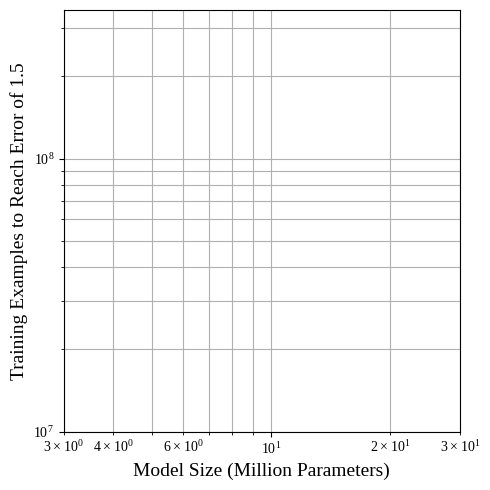

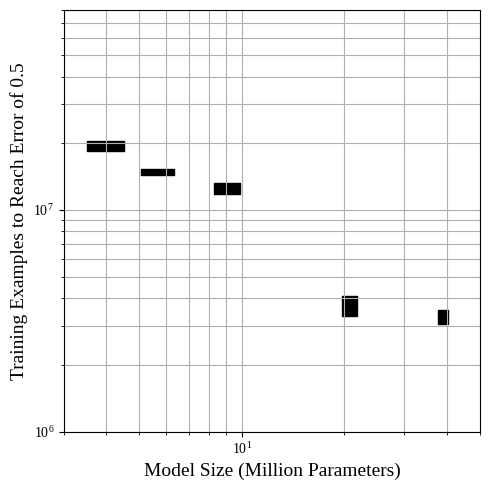

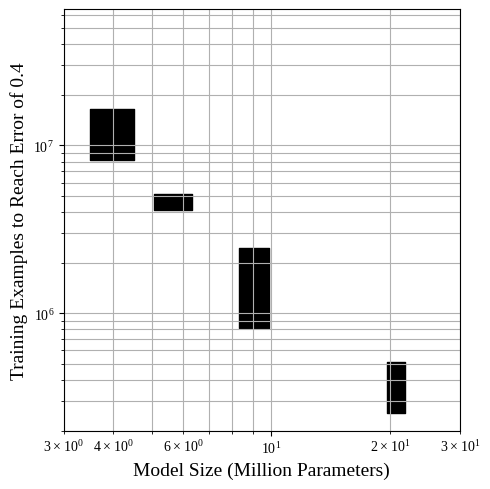

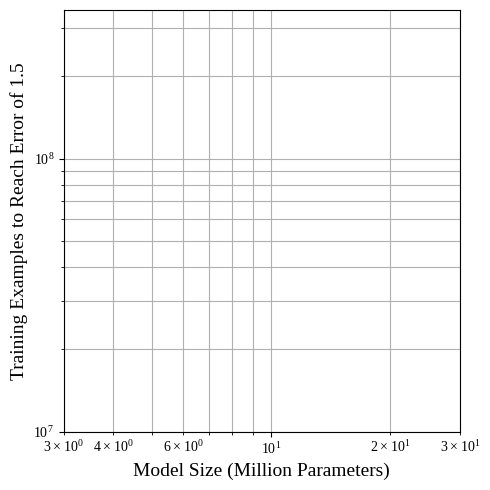

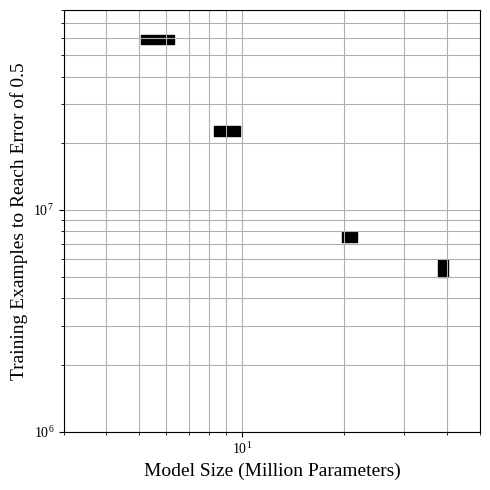

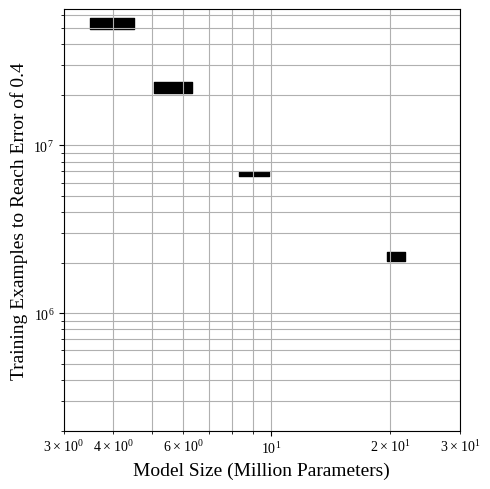

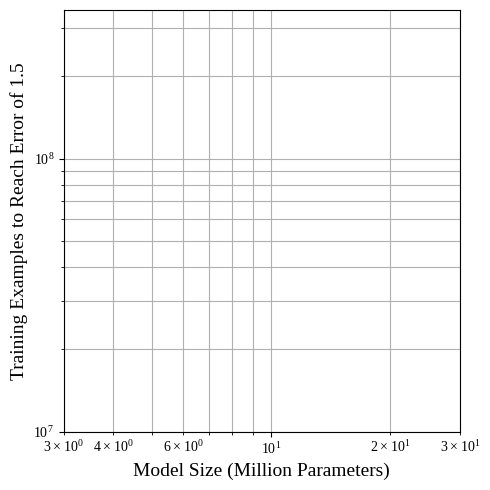

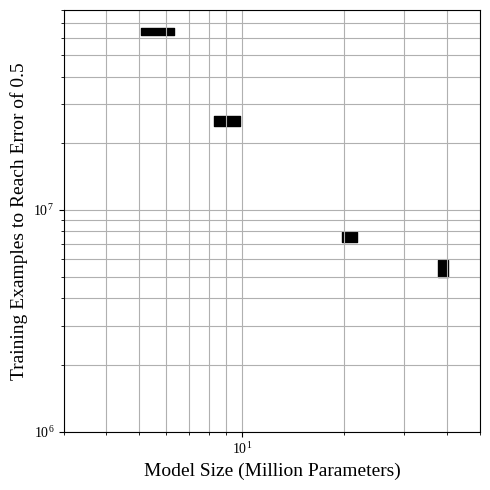

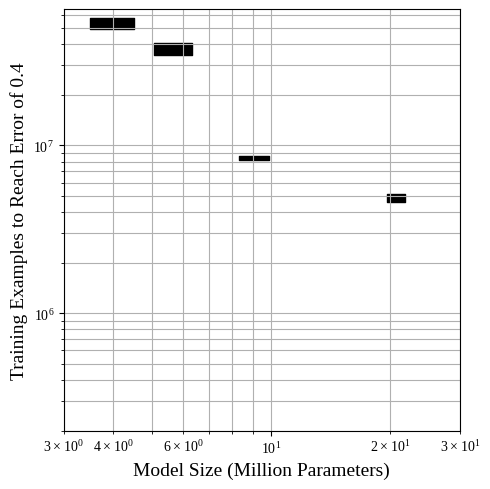

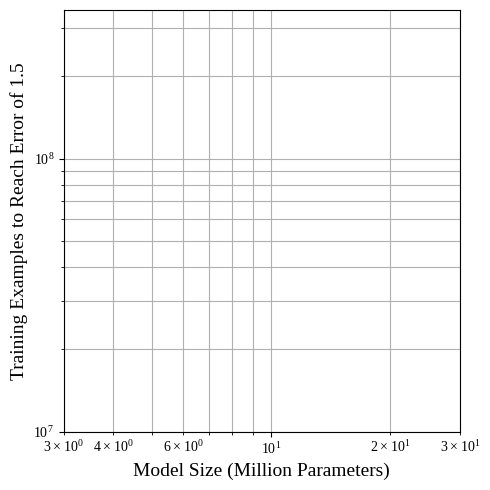

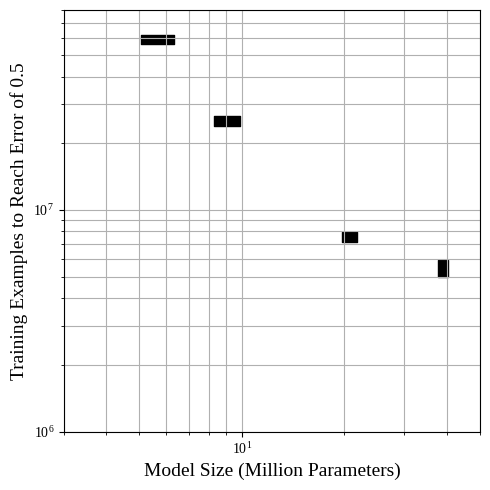

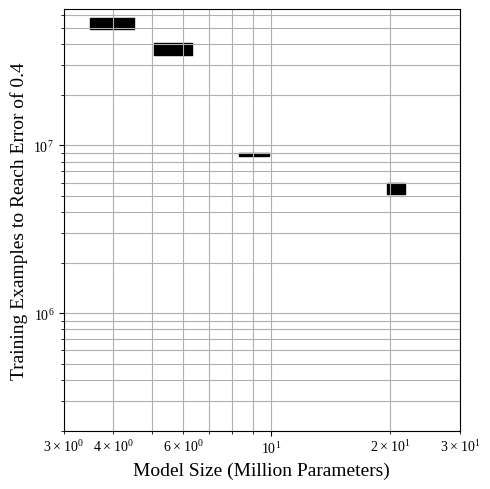

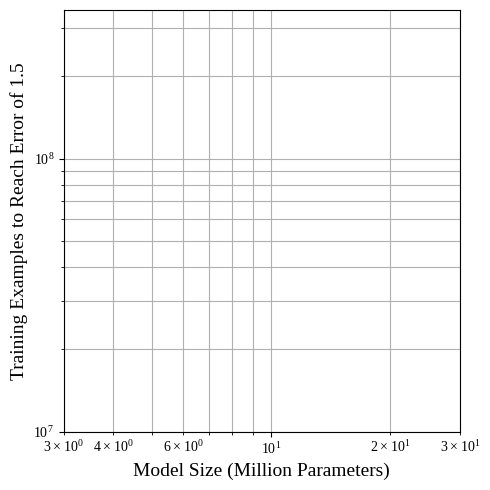

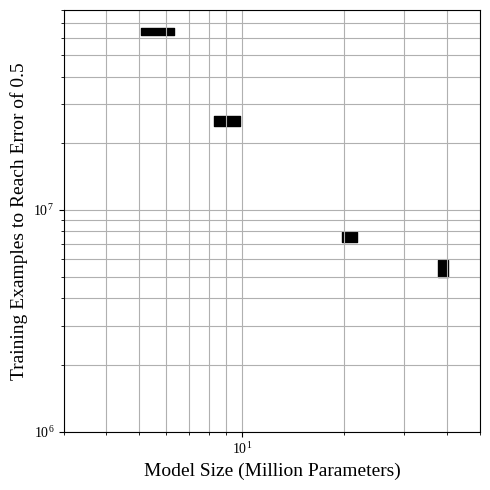

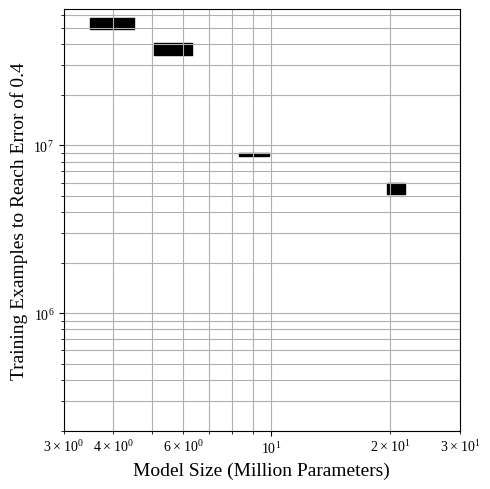

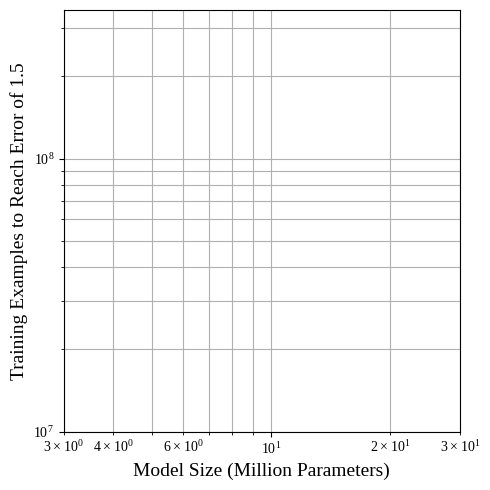

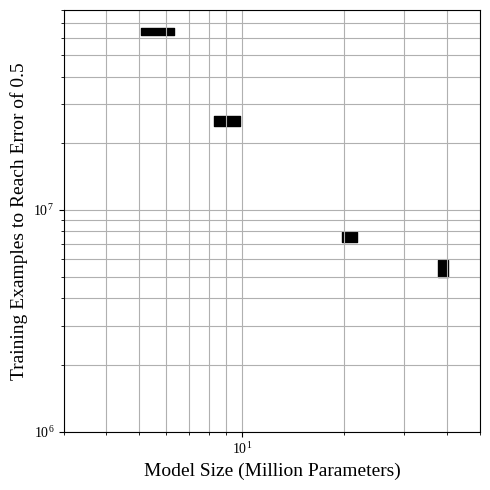

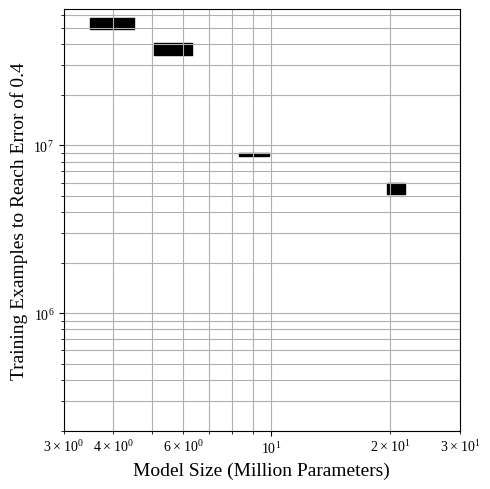

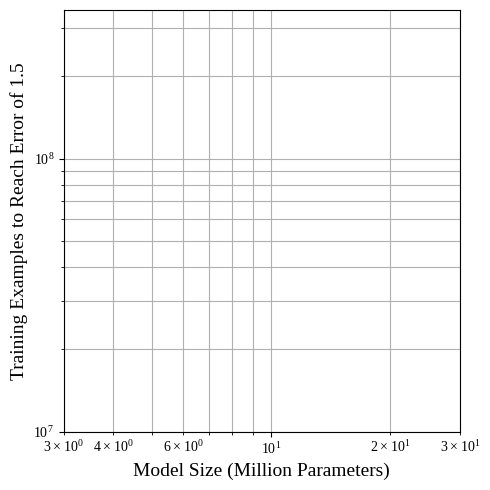

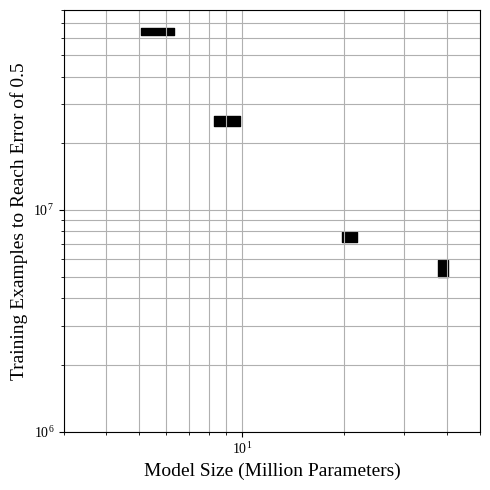

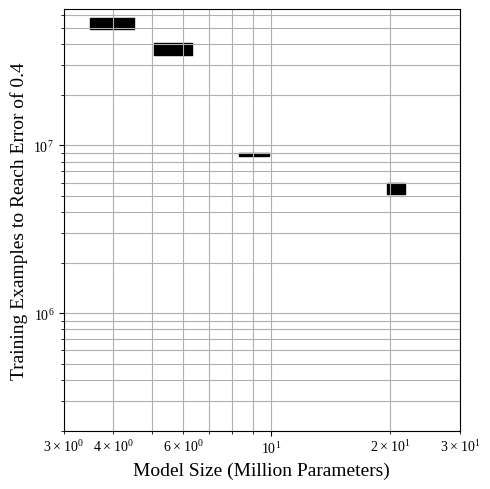

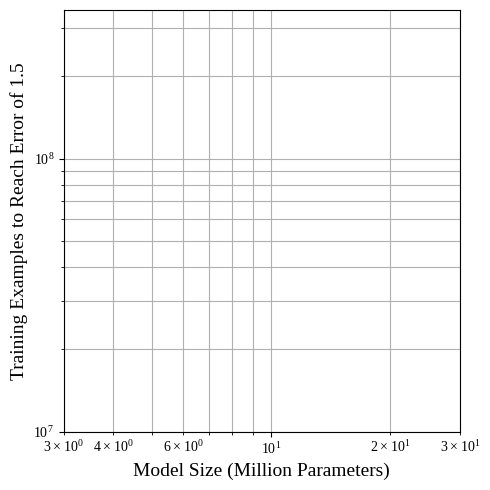

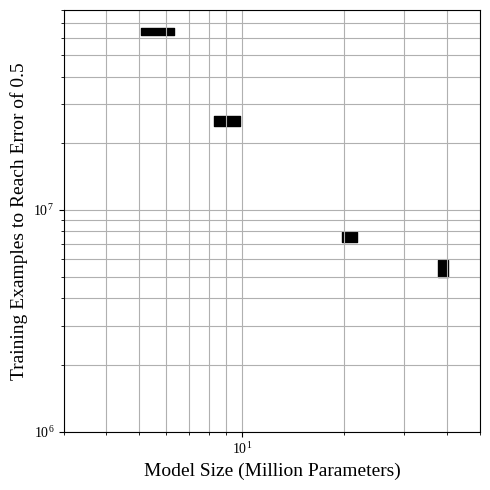

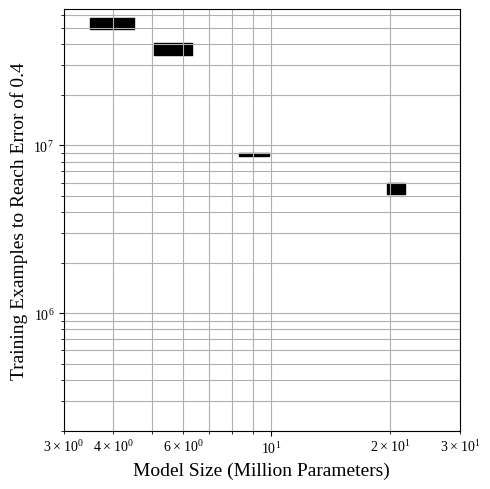

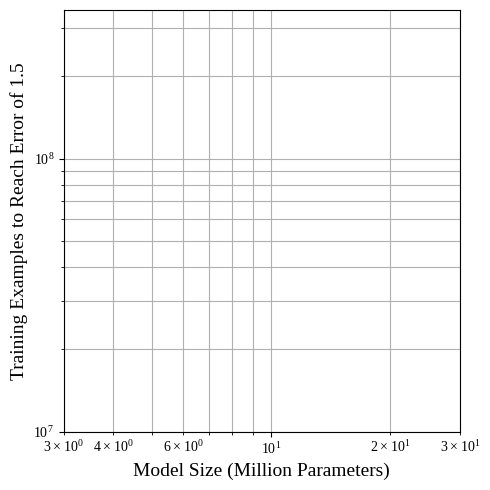

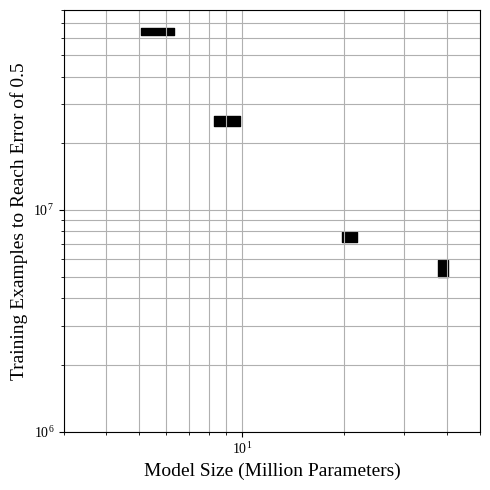

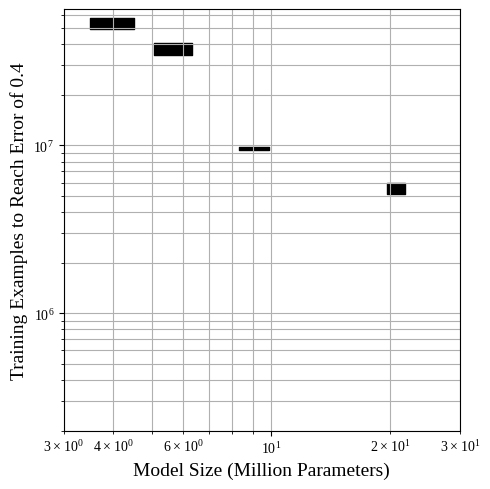

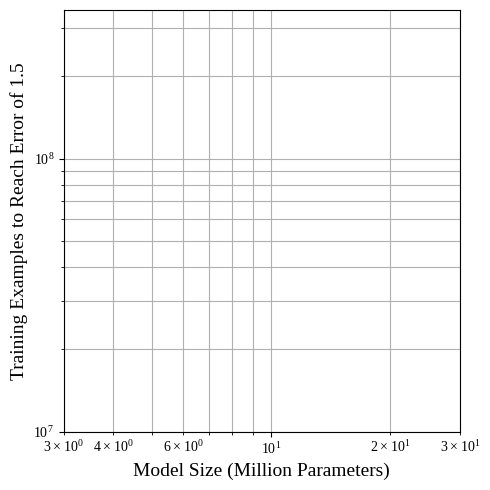

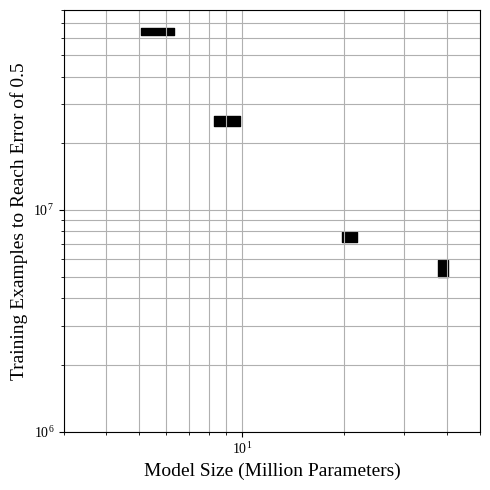

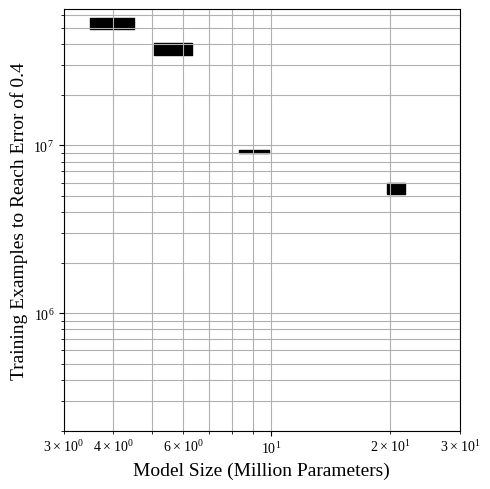

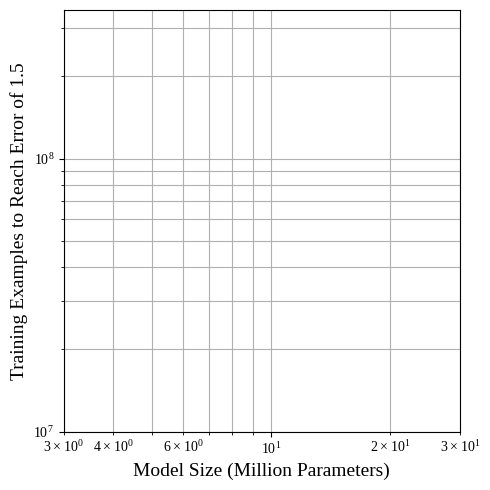

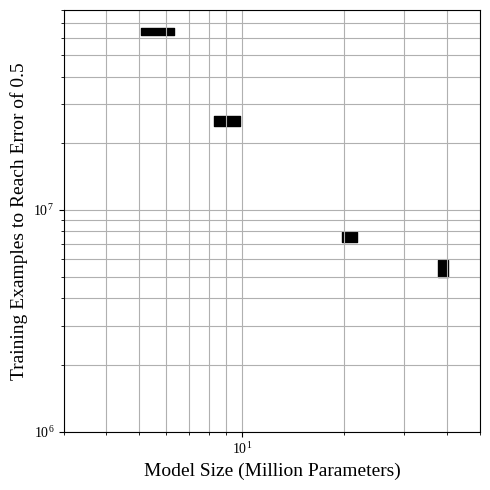

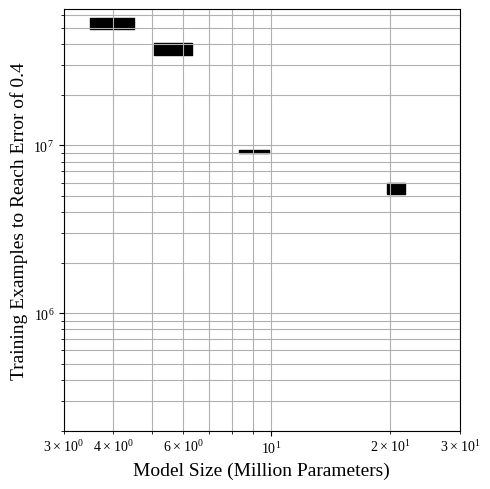

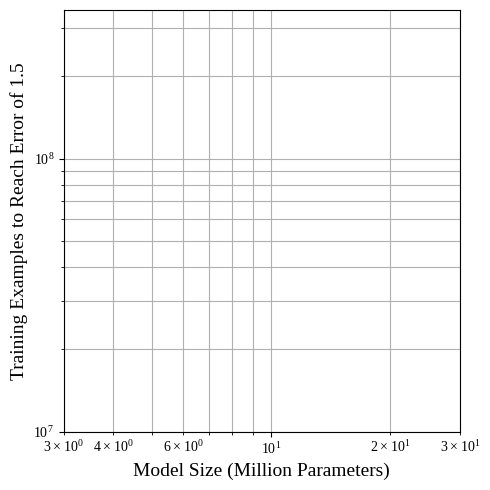

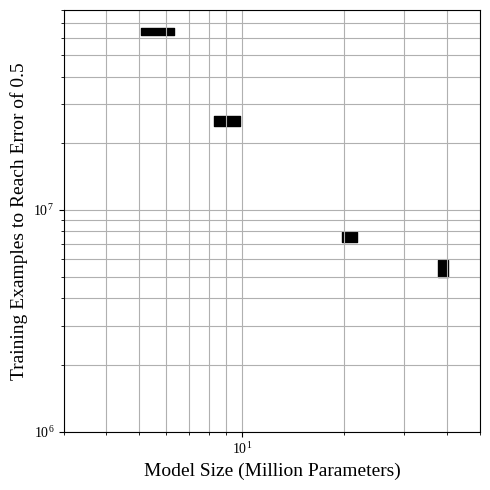

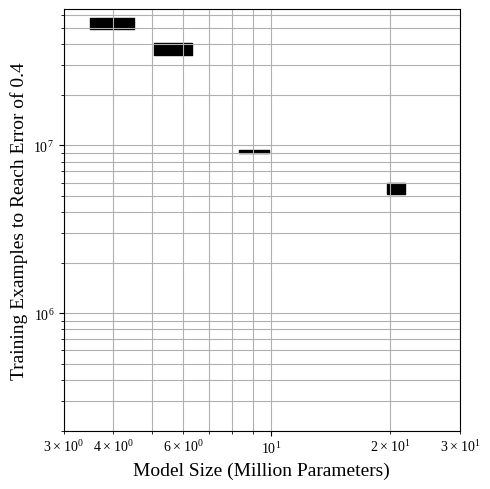

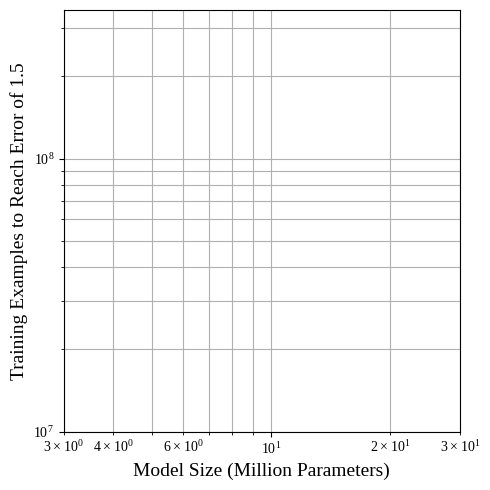

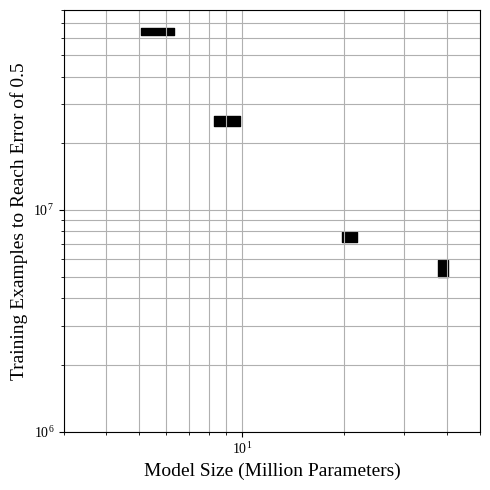

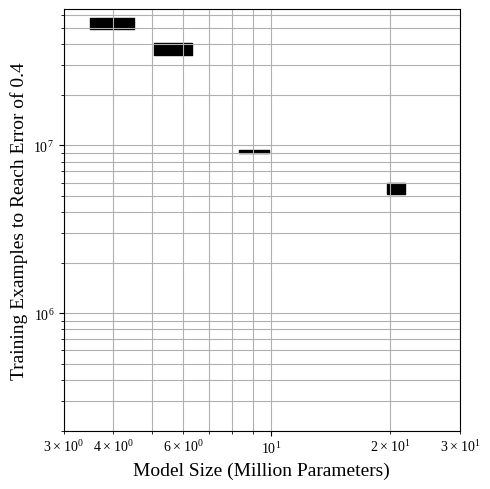

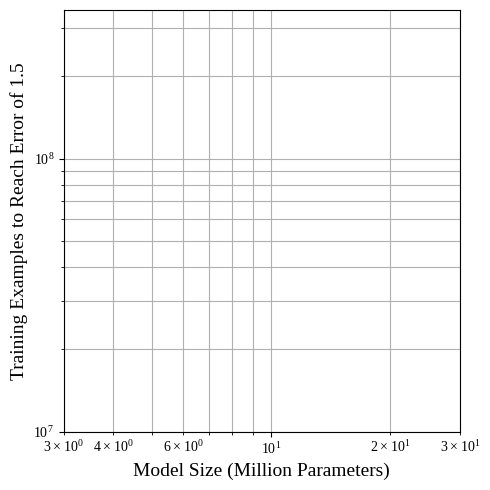

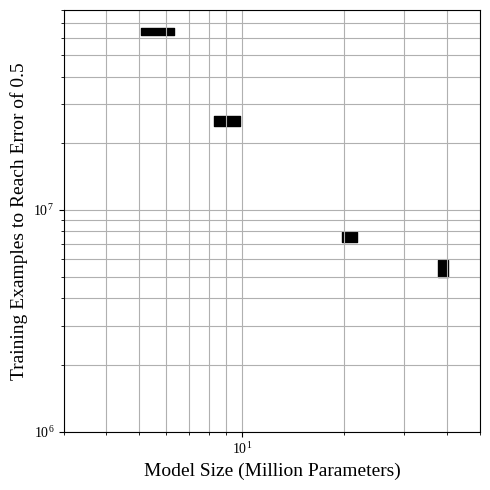

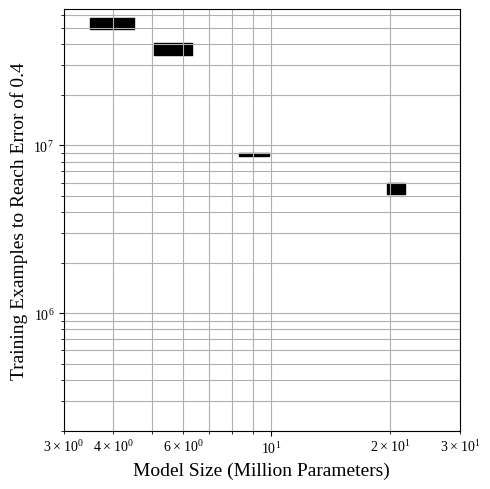

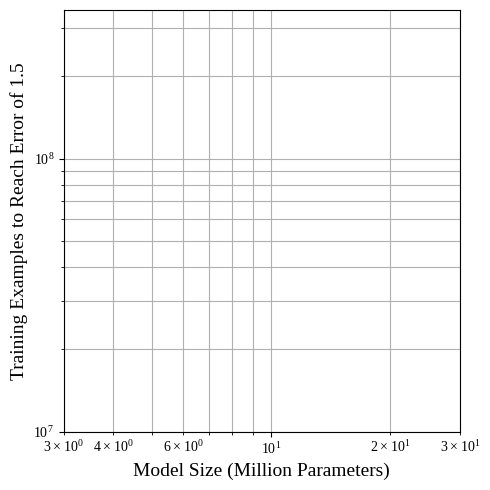

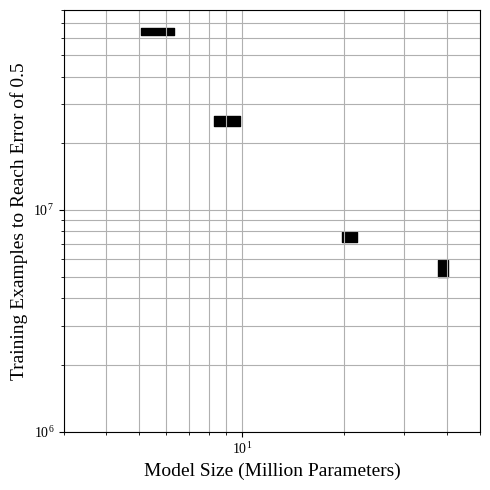

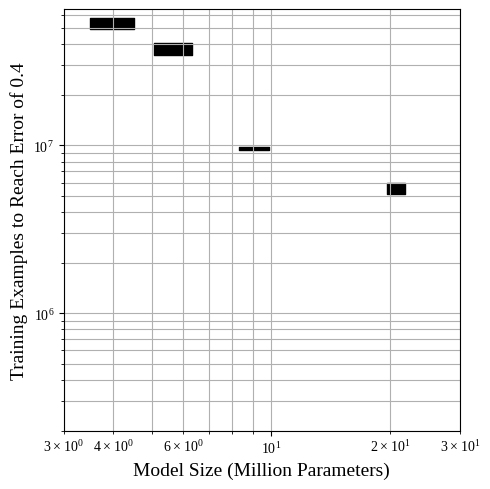

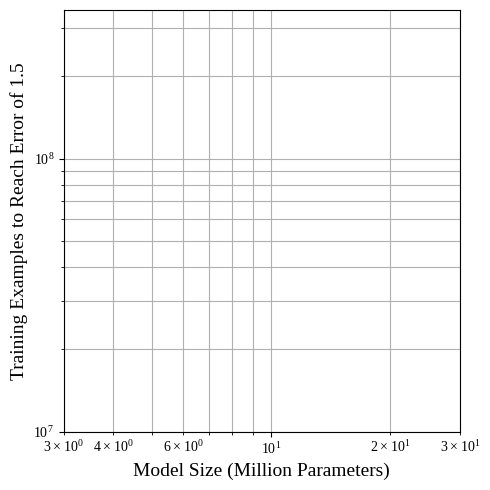

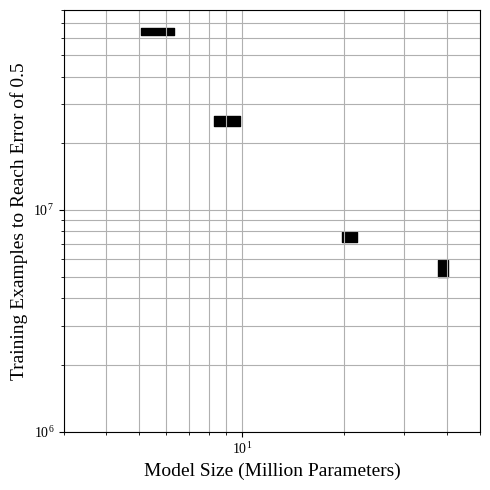

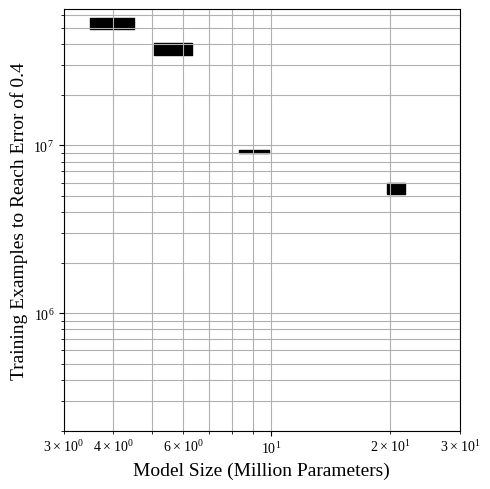

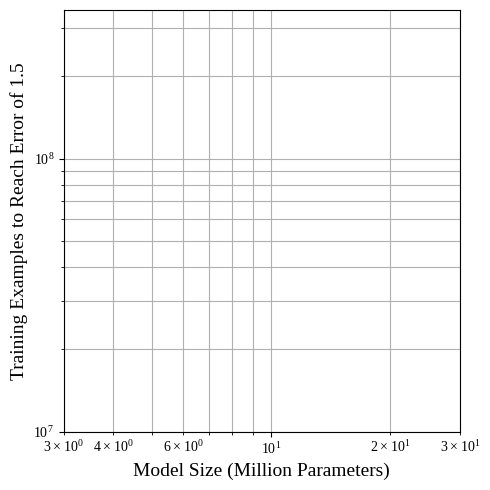

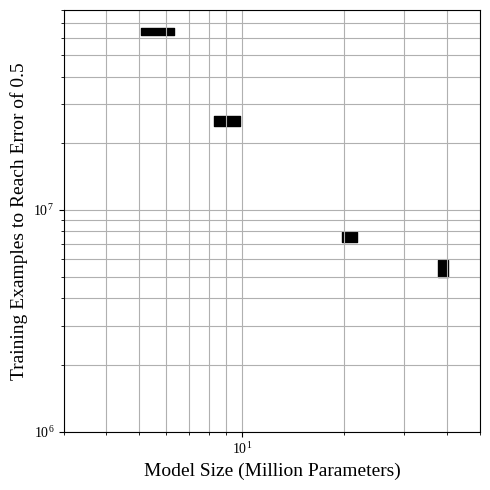

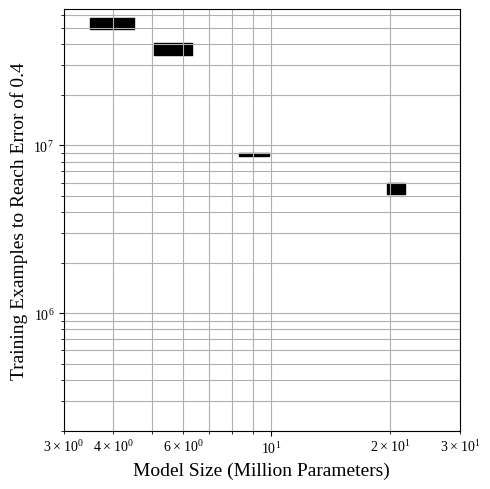

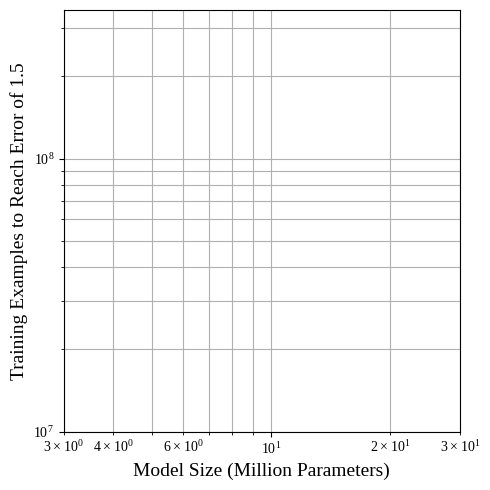

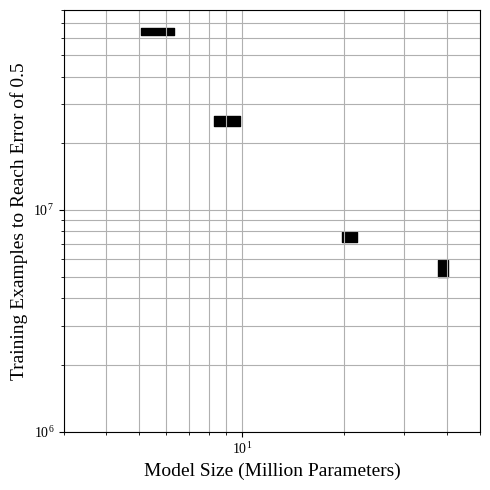

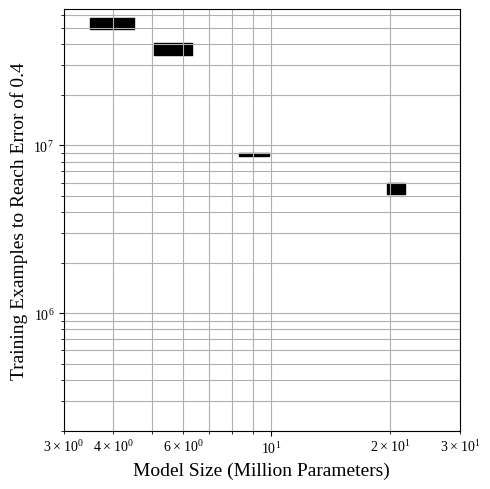

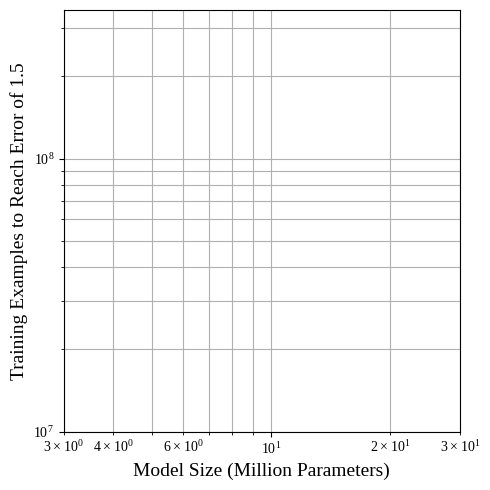

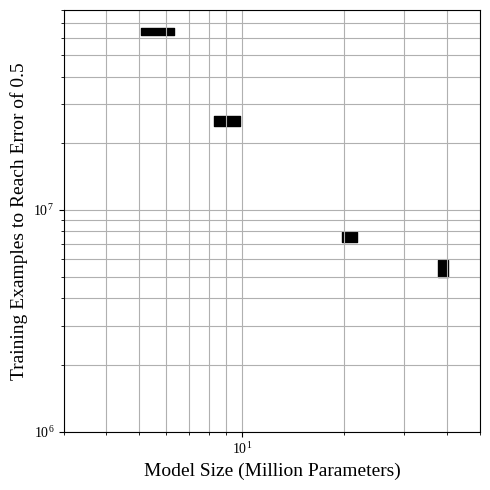

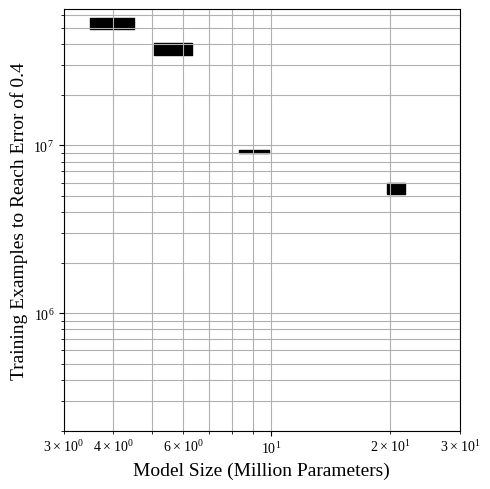

In [35]:
haystack_lens = np.arange(1,20)
for haystack_len in haystack_lens:
    phase_tr_vs_model_size(config, experiment_dict, haystack_len)

<class 'dict'>
model_dir: ../outputs/GPT2/, experiment: 250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000
Loading train conv quartiles from ../outputs/GPT2/250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_1.pkl
Loading train conv quartiles from ../outputs/GPT2/250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_1.pkl
Loading x_values from ../outputs/GPT2/250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000/needles/train_conv/x_values_haystack_len_1.npy


experiment: 250509_232740.d8a2db_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.765825198443491e-06_num_train_sys_40000, model_size: huge
shape of qs[1] (31,)
larger_than_cut

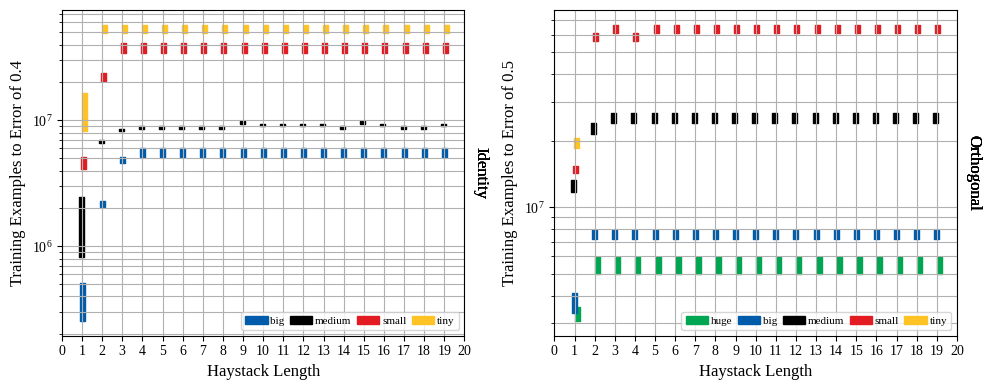

In [36]:
phase_tr_vs_haystack_len(config, experiment_dict, colors)